In [1]:
import cv2
import os
pjoin = os.path.join
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
fish_im = []
for fn in sorted([fn for fn in os.listdir('./data') if fn.startswith('fish')]):
    fish_im.append(cv2.imread(pjoin('data',fn), cv2.IMREAD_UNCHANGED))
    assert fish_im[-1].shape[2] == 4, 'No alpha channel'
    #cv2.imwrite(fn, cv2.resize(fish_im[-1],(64,64)))
    
bg_im = []
for fn in sorted([fn for fn in os.listdir('./data') if fn.startswith('bg')]):
    bg_im.append(cv2.imread(pjoin('data',fn)))

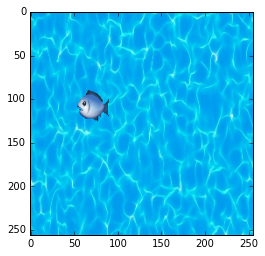

In [3]:
def random_im():
    bg_i = np.random.randint(0, high=len(bg_im), size=1)[0]
    fsh_i = np.random.randint(0, high=len(fish_im), size=1)[0]
    bg = np.copy(bg_im[bg_i])
    fsh = np.copy(fish_im[fsh_i])
    fsh[:,:,3] /= 255
    scale = np.random.rand(1)[0] * 1.5 + 0.25
    fsh = cv2.resize(fsh, (int(scale*fsh.shape[0]), int(scale*fsh.shape[1])))
    y0=np.random.randint(0, bg.shape[0]-fsh.shape[0], 1)[0]
    x0=np.random.randint(0, bg.shape[1]-fsh.shape[1], 1)[0]
    bg[y0:y0+fsh.shape[0], x0:x0+fsh.shape[1], :] = fsh[:,:,:3]*fsh[:,:,3,np.newaxis] + bg[y0:y0+fsh.shape[0], x0:x0+fsh.shape[1], :]*(1-fsh[:,:,3,np.newaxis])
    return bg
    
im = random_im()
plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

In [4]:
from keras import backend as K

Using TensorFlow backend.
